<a href="https://www.kaggle.com/code/sumeet2807/linear-regression-r2-0-85-neural-net?scriptVersionId=140717615" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook deals with Linear Regression and its basic interpretation. Problems of multicollinearity, data transformations and new feature creation have been touched upon to keep balance between predictive power and interpretability.

Finally a small comparison has been made between predictive power of a simple neural network and Linear Regression for this scenario

In [1]:
#Initialization
!pip install pingouin==0.3.8
import pandas as pd
import seaborn as sns
import pingouin as pg
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression as Log
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor as RFR
from scipy.stats import probplot
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm
from sklearn.decomposition import FactorAnalysis as FA


# Tolerance function
def print_lintol(df):
  for col in df.columns:
    x = df.drop(col,axis=1)
    y = df[col]
    clf = LR()
    clf.fit(x,y)
    print(col)
    print(1 - clf.score(x,y))

#Stepwise Regression

def step_reg(df,target_col,significance_threshold,adj_r2_threshold):
  remaining_col = df.columns.to_list()
  remaining_col.remove(target_col)
  included_cols = []
  col_to_include = df.corr().drop(target_col).sort_values(target_col,ascending=False).index[0]
  print(col_to_include)
  included_cols.append(col_to_include)
  remaining_col.remove(col_to_include)
  clf = LR()
  X = df[included_cols].to_numpy()#[...,np.newaxis]
  y = df[target_col].to_numpy()
  #*******optional***
  scaler = StandardScaler()
  scaler.fit_transform(X)
  # #********
  clf.fit(X,y)
  max_adj_r2 = 1-(1-clf.score(X,y))*(X.shape[0]-1)/(X.shape[0]-X.shape[1]-1)
  print(max_adj_r2)
  while(len(included_cols) < (len(df.columns)-1)):
    max_r = 0
    col_to_include = None
    for col in remaining_col:
      df_temp = df[included_cols + [col,target_col]]
      pc = pg.partial_corr(df_temp,col,target_col,covar=included_cols)
      if (abs(pc['r'].iloc[0]) > max_r) and (pc['p-val'].iloc[0] < significance_threshold):
        col_to_include = col
        max_r = abs(pc['r'].iloc[0])
    if col_to_include == None:
      break
    included_cols.append(col_to_include)
    remaining_col.remove(col_to_include)
    clf = LR()
    #*******optional***
    scaler = StandardScaler()
    scaler.fit_transform(X)
    #********
    X = df[included_cols].to_numpy()
    y = df[target_col].to_numpy()
    clf.fit(X,y)
    Adj_r2 = 1-(1-clf.score(X,y))*(X.shape[0]-1)/(X.shape[0]-X.shape[1]-1)
    if (Adj_r2 - max_adj_r2) < adj_r2_threshold :
      print('adjusted r2 voilated')
      included_cols.remove(col_to_include)
      remaining_col.append(col_to_include)
      break
    else:
      print(col_to_include) 
      print(Adj_r2) 
      max_adj_r2 = Adj_r2
      min_tol = 1
      min_tol_col = None
      for col in included_cols:
        x = df[included_cols].drop(col,axis=1)
        y = df[col]
        clf = LR()
        #*******optional***
        scaler = StandardScaler()
        scaler.fit_transform(X)
        #********
        clf.fit(x,y)
        tol = 1 - clf.score(x,y)
        if tol < min_tol:
          min_tol = tol 
          min_tol_col = col
      print('min tolerance - ' + min_tol_col + ' - ' + str(min_tol))
  return(included_cols)



# Neural net
class basic_net(tf.keras.Model):
  def __init__(self,h1,h2,drop):
    super(basic_net, self).__init__()
    self.dense1 = tf.keras.layers.Dense(h1,'relu')
    self.dense2 = tf.keras.layers.Dense(h2,'relu')
    self.dense3 = tf.keras.layers.Dense(1)
    self.drop = tf.keras.layers.Dropout(drop)
  def call(self,x):
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(self.drop(x))
    return(x)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)  


loss = tf.keras.losses.MeanSquaredError()


     |████████████████████████████████| 223 kB 13.0 MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.8-py3-none-any.whl size=221688 sha256=f9d37a3b1a277c6ad6e46e7079d0554d15aee7f4b04ece81a1d862c494ed5367
  Stored in directory: /root/.cache/pip/wheels/2c/1c/b9/4b0d55135badf2f2e1b12ab1cd1747a950be8bcd5380280b8e
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=0991b8fd99669a8729fb23d02c3027416e90cd13d33511f2d220ea3f380c1060
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Load data
dfo = pd.read_csv('../input/housesalesprediction/kc_house_data.csv',encoding='latin').sample(frac=1)
dfo = dfo.drop(['id','date'],axis=1)
dfo['age'] = dfo['yr_built'].max() - dfo['yr_built'] # Adding a new feature, which I think could be better than year built
ttr = 0.25
df_test = dfo.iloc[:int(ttr*len(dfo))]
df_train = dfo.iloc[int(ttr*len(dfo)):]
df_train_pristine = df_train.copy()
df_test_pristine = df_test.copy()

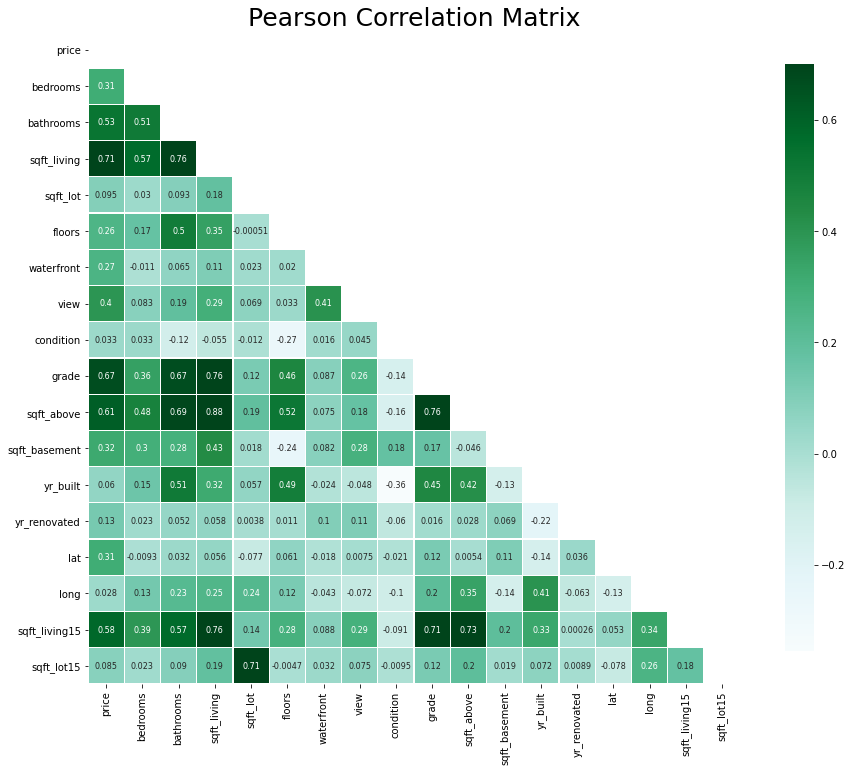

In [3]:
# Visualization Borrowed from - https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices - Thanks !
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15']

mask = np.zeros_like(df_train[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_train[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

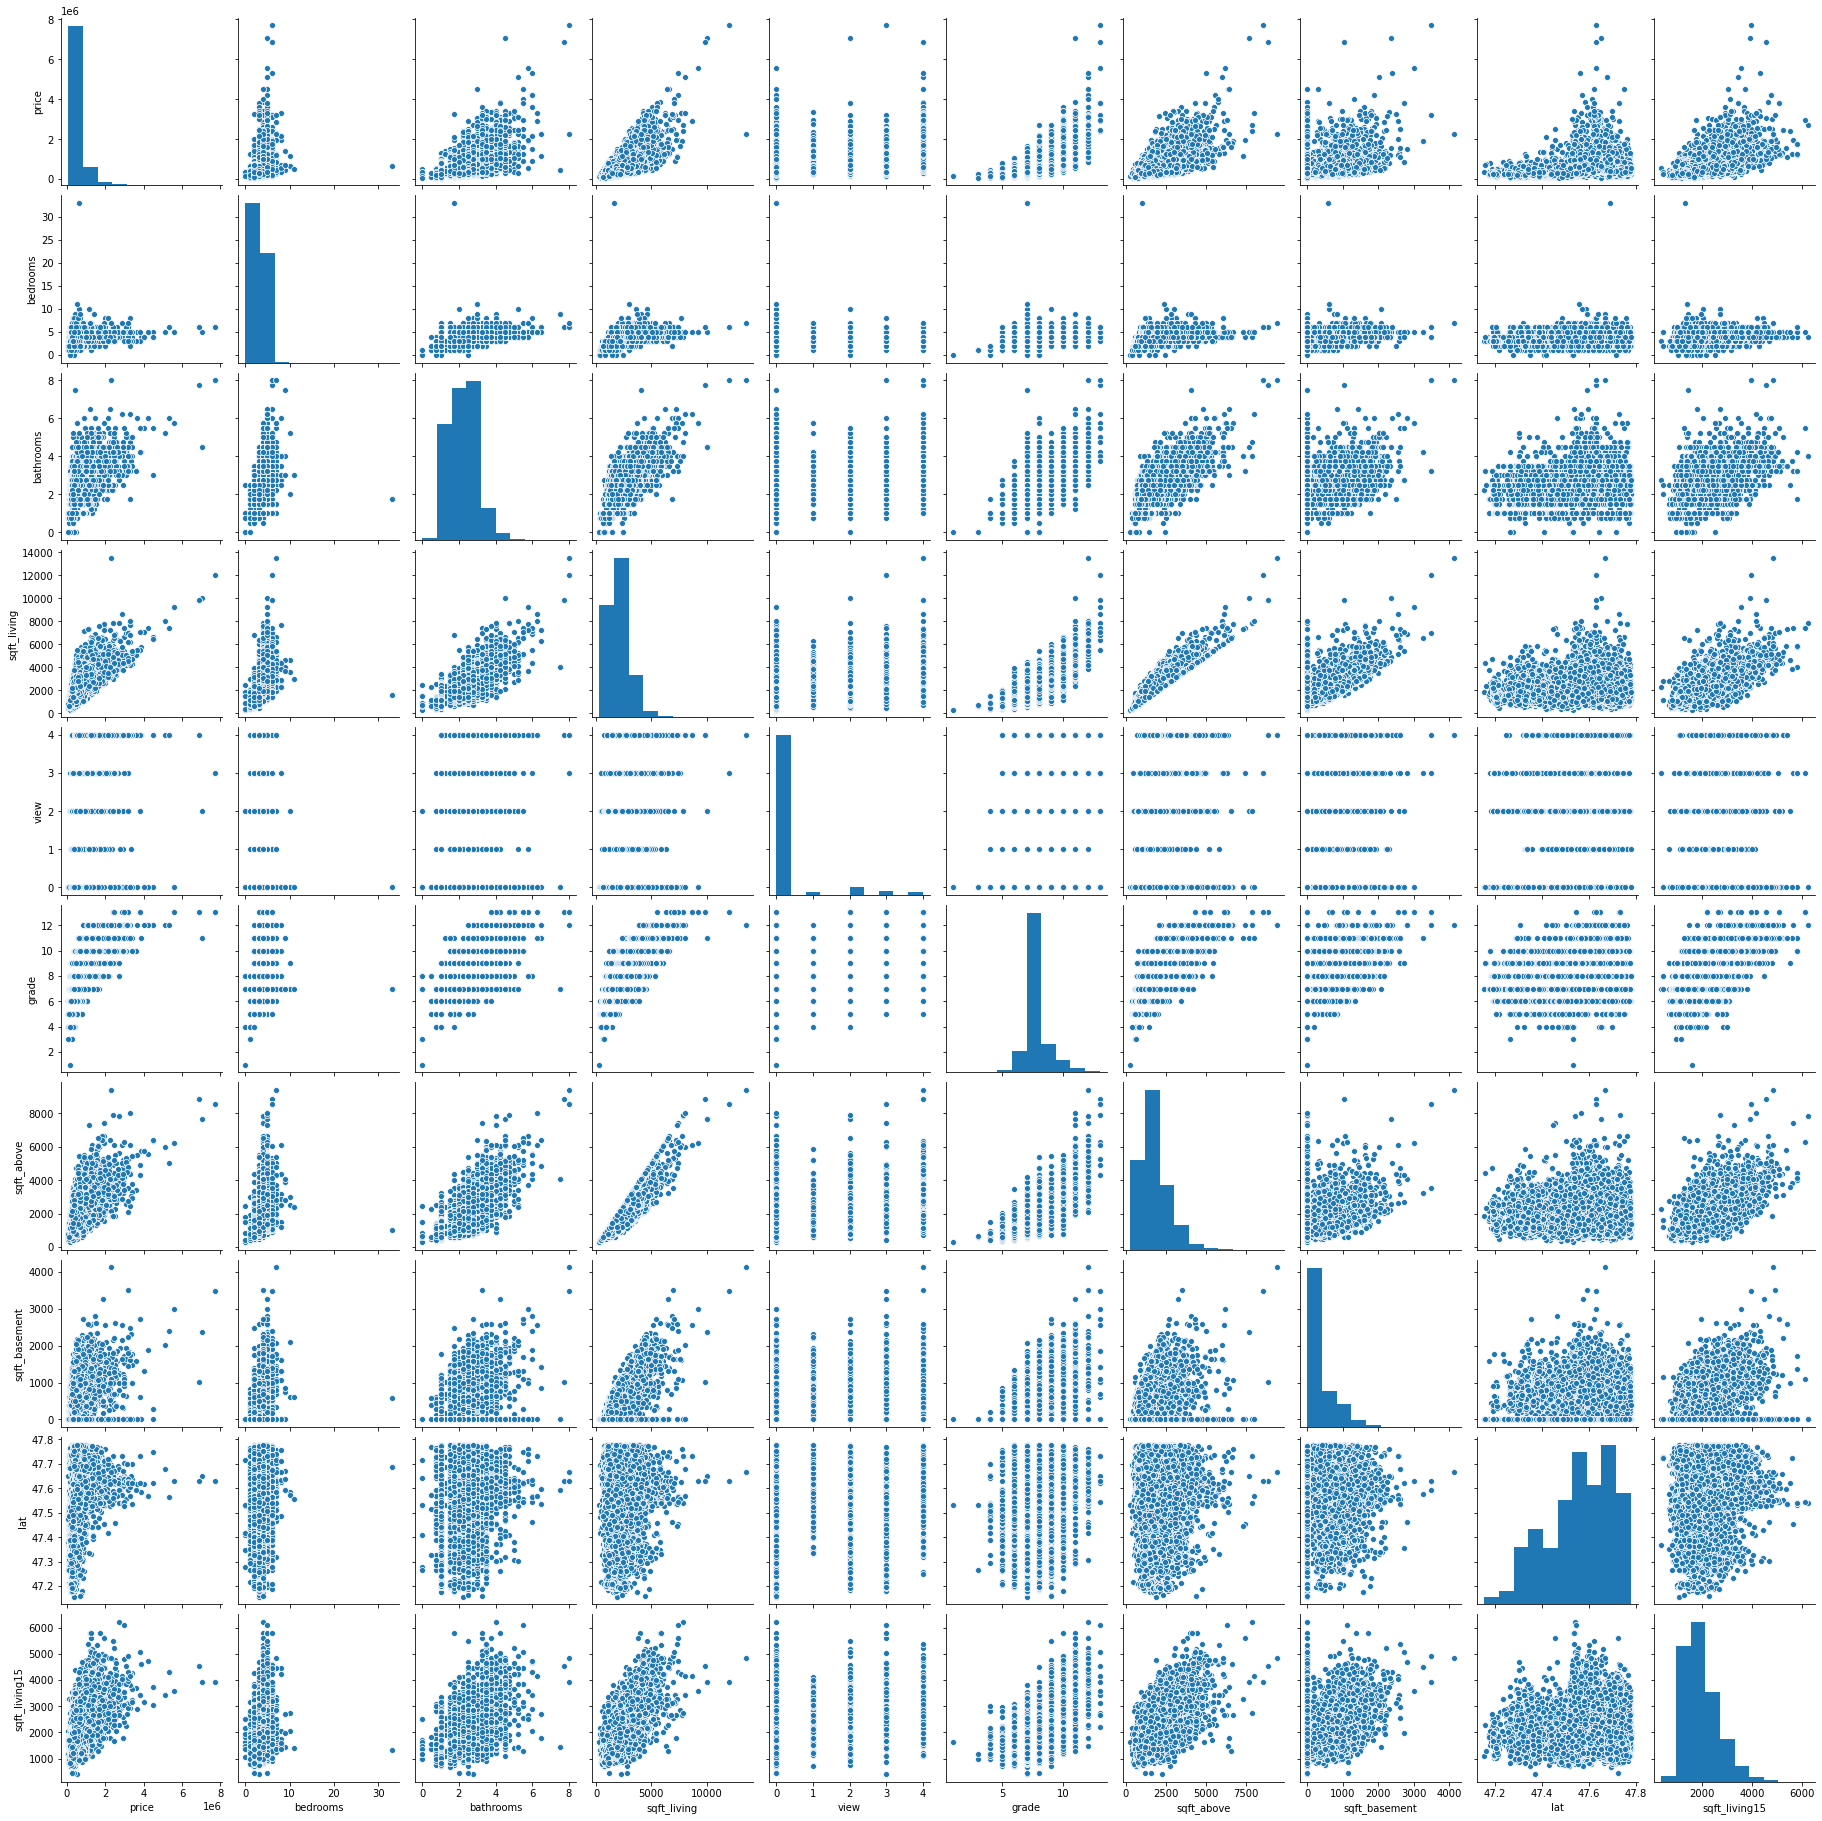

In [4]:
# Lets get the features having significant(I will take it as > 0.3) correlation with price. We may include the other features as well, but there is little hope they would be any useful.
significant_features = ['price','bedrooms','bathrooms','sqft_living',
            'view','grade','sqft_above','sqft_basement','lat','sqft_living15']
sns.pairplot(df_train_pristine[significant_features])

My aim is to create a Linear Model. So, I need to keep in mind the important assumptions that come with it. These are: 
1. Linear relationship: There exists a linear relationship between the independent variable, x, and the dependent variable, y.

2. Independence: The residuals are independent. In particular, there is no correlation between consecutive residuals in time series data.

3. Homoscedasticity: The residuals have constant variance at every level of x.

4. Normality: The residuals of the model are normally distributed.

So, I need to try to do my best to cater all four assumptions through some transformations. It never guarantees, and in most cases, it will not be possible to completely abide by these principles with a mere human's limited knowledge of feature transformations.

Pairplots for 'Price'(dependant variable) shows fair amount of heteroscedasticity. Another point to note is, most of the variables shows a right skewed gaussian distribution. This is not a violation linear model, but fixing the skew with a log transformation, sometimes also fixes the heteroscedasticity. Thats exactly what I will be doing next. But before that, lets see a baseline model with all the variables.

In [5]:
#baseline Regression
scaler = StandardScaler()
X = df_train_pristine.drop('price',axis=1).to_numpy()
y = df_train_pristine['price'].to_numpy()
X = scaler.fit_transform(X)
x_test = df_test_pristine.drop('price',axis=1).to_numpy()
x_test = scaler.transform(x_test)
y_test = df_test_pristine['price'].to_numpy()

clf_baseline = LR()
clf_baseline.fit(X,y)

R2 = clf_baseline.score(x_test,y_test)
print('R2 - ' + str(R2))
print('adj R2 - ' + str(1-(1-R2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))
print(df_test_pristine.drop('price',axis=1).columns.to_list())
print(clf_baseline.coef_)

R2 - 0.6967352943100504
adj R2 - 0.6956648820105689
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age']
[-3.55569533e+04  3.35012965e+04 -7.55438621e+17  4.50883181e+03
 -2.01308049e+02  5.15912978e+04  3.87926239e+04  1.71957379e+04
  1.12506178e+05  6.81232197e+17  3.59481685e+17 -1.91942039e+18
  6.72645937e+03 -2.84622958e+04  8.36976071e+04 -2.98327804e+04
  1.21412619e+04 -1.08474171e+04 -1.91942039e+18]


Let's Transform some features now.

In [6]:
#Feature transformations on complete data
# df_pristine = dfo.copy()
df = dfo
df['sqft_above'] = np.log(df['sqft_above'].to_numpy())
df['price'] = np.log(df['price'].to_numpy())
df['sqft_living'] = np.log(df['sqft_living'].to_numpy())
df['sqft_living15'] = np.log(df['sqft_living15'].to_numpy())
df['sqft_basement'] = np.log(df['sqft_basement'].to_numpy() + 1) # added 1, as log of zero is not defined.


Lets plot the graphs again and see the difference.

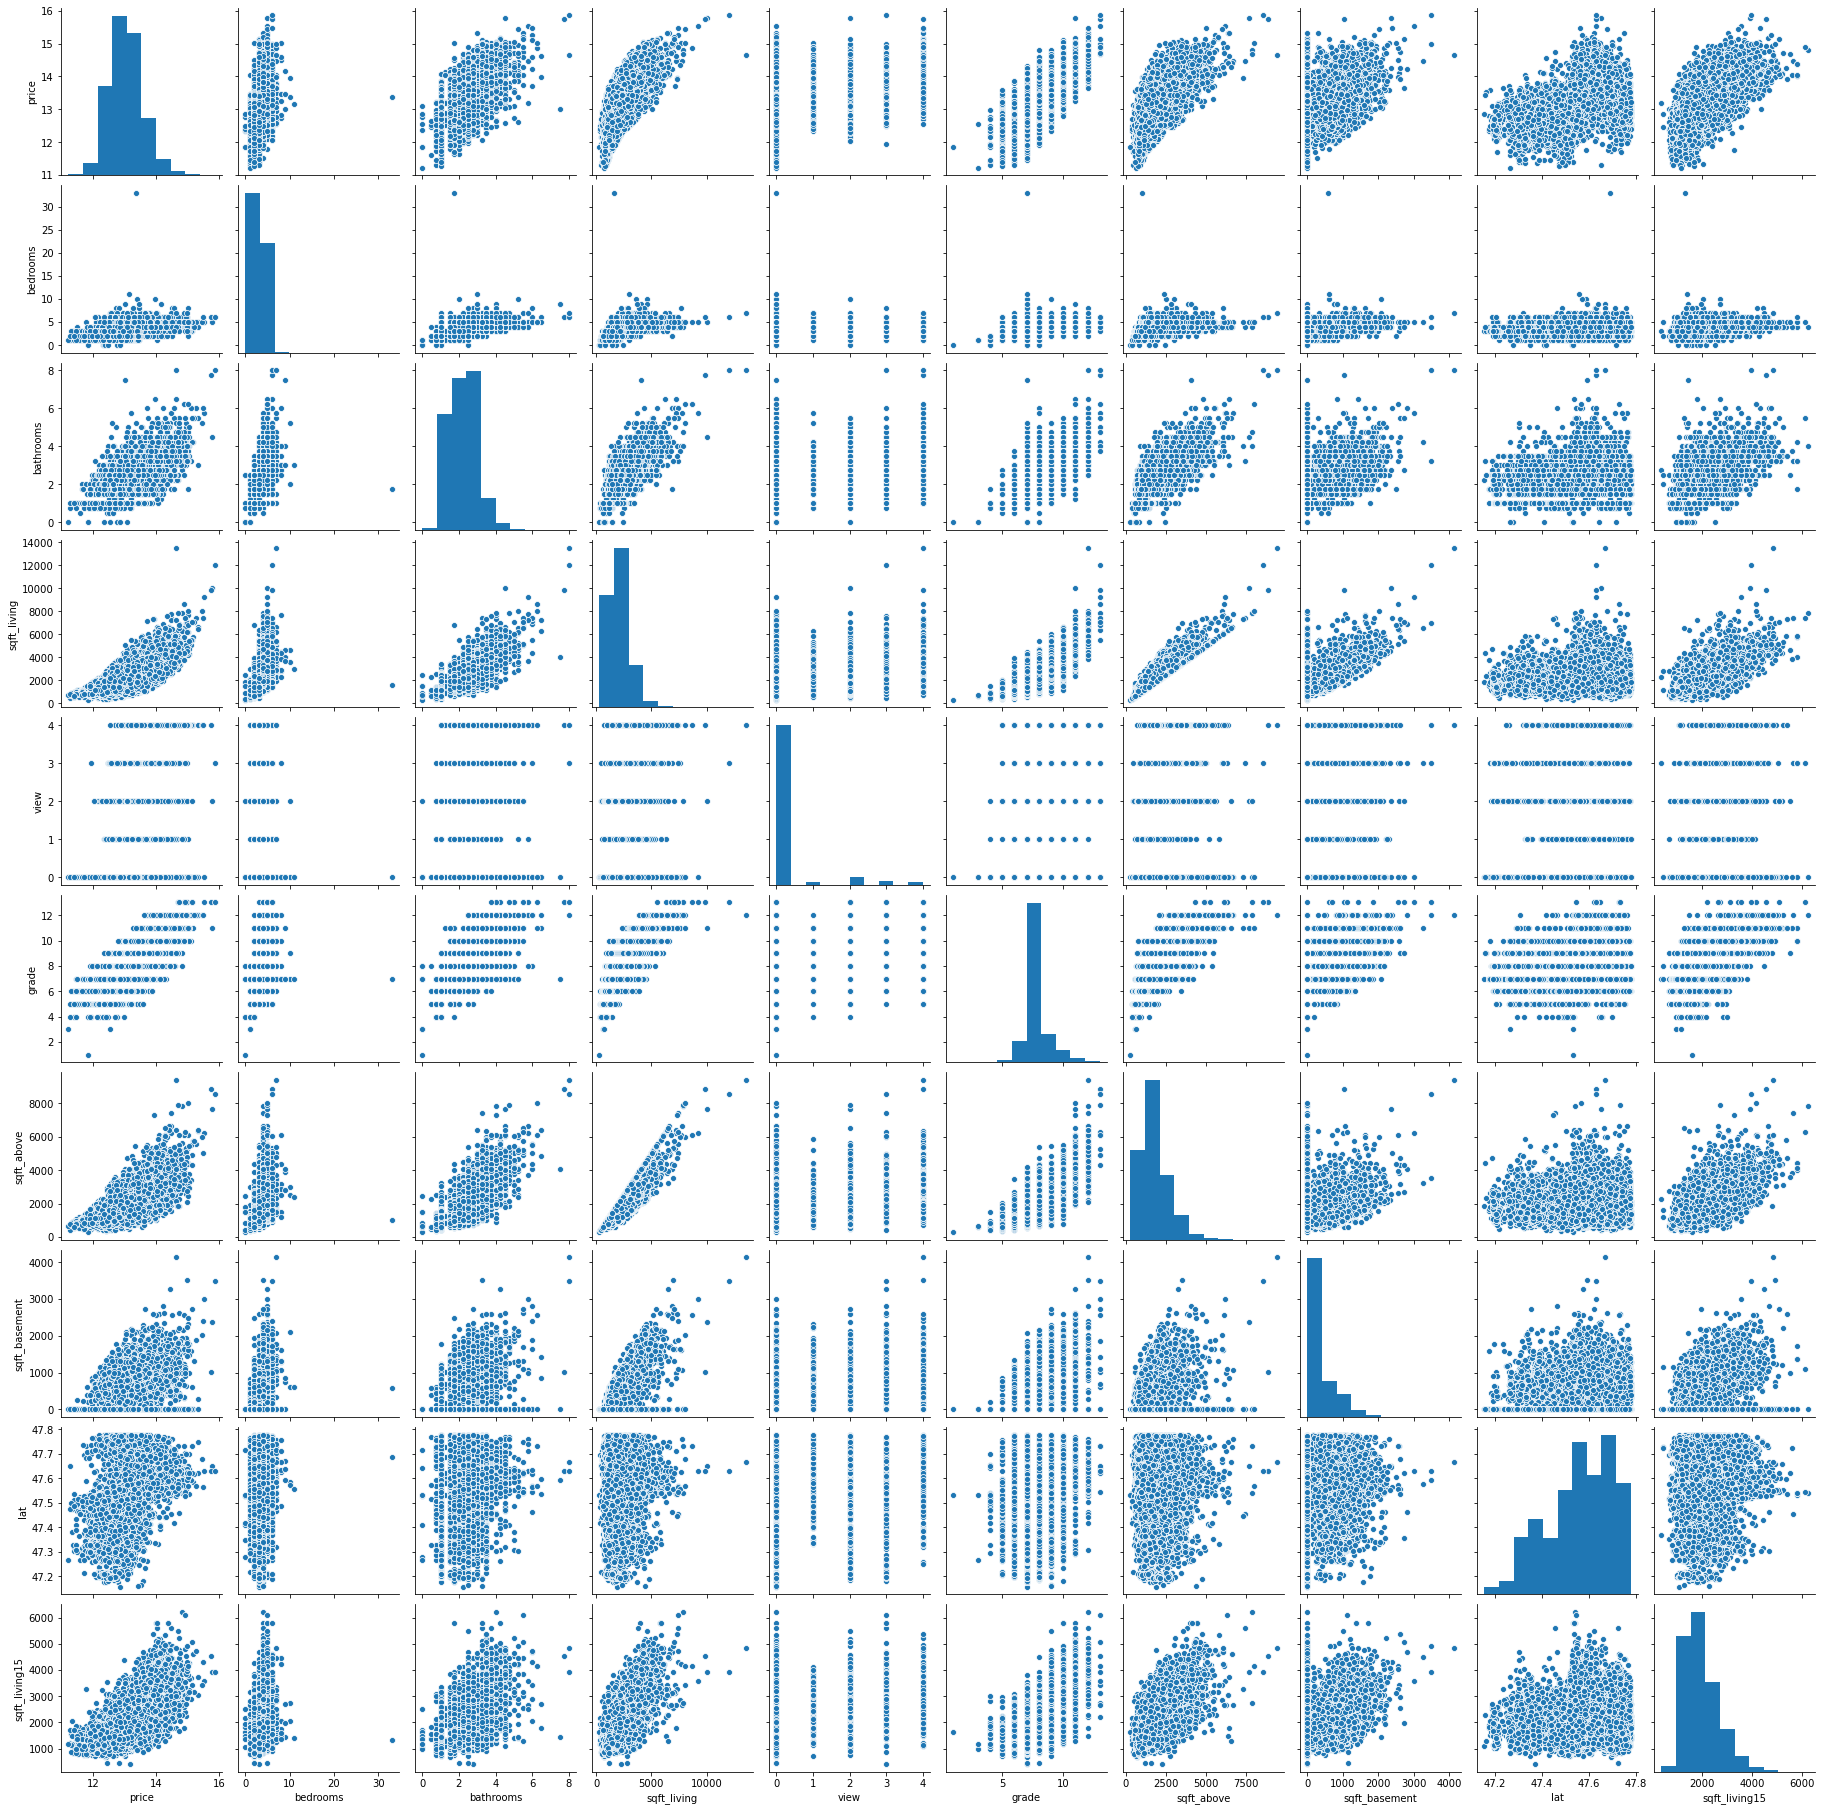

In [7]:
sns.pairplot(df_train[significant_features])

Above plots look much better than the one with the unprocessed variables. Transformations have significantly improved the heteroscedasticity problem, and we can see a visible linear relationship. There is a lot of scope for improvement by modifying the transformations, which involves a lot of creativity. I will stick to simple transformations for now. 

Before applying linear regression, I will check for multicollinearity problem. While not a problem for the predictive performance, multicollinearity can significantly hamper model interpretation by affecting the coefficient determination. I will simply print the tolerances of the different variables by regressing the independant variables against themselves.

In [8]:
#Tolerance values
print('Tolerances for different variables')
print_lintol(df_train.drop('price',axis=1))

Tolerances for different variables
bedrooms
0.6130664854885286
bathrooms
0.2972421412394951
sqft_living
0.0
sqft_lot
0.48141409750362474
floors
0.5005801382192288
waterfront
0.8240874878761454
view
0.6920690180968971
condition
0.8036519605553747
grade
0.28966347700835193
sqft_above
0.0
sqft_basement
0.0
yr_built
0.0
yr_renovated
0.8729835187552449
zipcode
0.6025950894820745
lat
0.8464391132928977
long
0.5460426972993402
sqft_living15
0.33490312843498127
sqft_lot15
0.4746985363754649
age
0.0


Significant tolerance problems with five variables - 'sqft_above', 'sqft_living' , 'sqft_basement' , 'yr_built' and 'age'. There is high degree of multicollinearity among these variables, which is not surprising as 'age' is derived from 'year_built' & 'sqft_above' + 'sqft_basement'  = 'sqft_living' .
So I would never enter 'age' if I choose 'year_built' OR all three of the square footages together. 

Lets see if simple forward stepwise regression based on adjusted R squared of the model can take care of this. This will involve sequentially adding independant variables to the linear model based on the highest partial correlation it can achieve taking into account already entred variables, unless the model's adjusted r squared value wont significantly improve.

In [9]:
#stepwise_regression
target_col = 'price'
significance_threshold = 0.01
adj_r2_threshold = 0.003

selected_cols = step_reg(df_train,target_col,significance_threshold,adj_r2_threshold)    

grade
0.5006567336952261
lat
0.6362786854774485
min tolerance - grade - 0.9853062216932038
sqft_living
0.7074410523685317
min tolerance - grade - 0.41051358601590726
yr_built
0.7345133248813623
min tolerance - grade - 0.35464877234319636
view
0.747032869523099
min tolerance - grade - 0.34871277100560816
bathrooms
0.7518710486517979
min tolerance - sqft_living - 0.2830709792316004
sqft_living15
0.756837233872069
min tolerance - sqft_living - 0.2290331260374624
condition
0.7609918398472519
min tolerance - sqft_living - 0.22876289707264763
waterfront
0.7646699360276404
min tolerance - sqft_living - 0.22870715147140064
adjusted r2 voilated


Stepwise regression was successfull in avoiding selecting highly corelated variables together. First variable selected is grade, followed by 'sqft_living', 'lat' and 'yr_built'. Choosing adjusted r squared helps us maintain a balance between the degrees of freedom for model generalization and the predictive power. R squared simply improves with addition of extra dimensions at cost of generalizability and hence, may overfit. So, a tradeoff.

Lets try simple regression over a test and train set with the selected variables.

In [10]:
# Regression on transformed data
scaler = StandardScaler()
X = df_train[selected_cols].to_numpy()
y = df_train['price'].to_numpy()
X = scaler.fit_transform(X)
x_test = df_test[selected_cols].to_numpy()
x_test = scaler.transform(x_test)
y_test = df_test['price'].to_numpy()

clf_lr = LR()
clf_lr.fit(X,y)

R2 = clf_lr.score(x_test,y_test)
print('R2 - ' + str(R2))
print('adj R2 - ' + str(1-(1-R2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))
print(df_test[selected_cols].columns.to_list())
print(clf_lr.coef_)

R2 - 0.7575189077700737
adj R2 - 0.7571142480574704
['grade', 'lat', 'sqft_living', 'yr_built', 'view', 'bathrooms', 'sqft_living15', 'condition', 'waterfront']
[ 0.20197242  0.1902873   0.12252617 -0.09471362  0.0437774   0.06742431
  0.06346333  0.03714372  0.03533684]


We achieved adj R squared of 0.77 with major important features as 'grade', 'lat', 'sqft_living', 'yr_built'.

Lets see the residual plot to see if the error terms are evenly split across the different values of x, in otherwords, homoscedasticity. Also, I will check if the error terms are normally distributed for basic linear regression. 

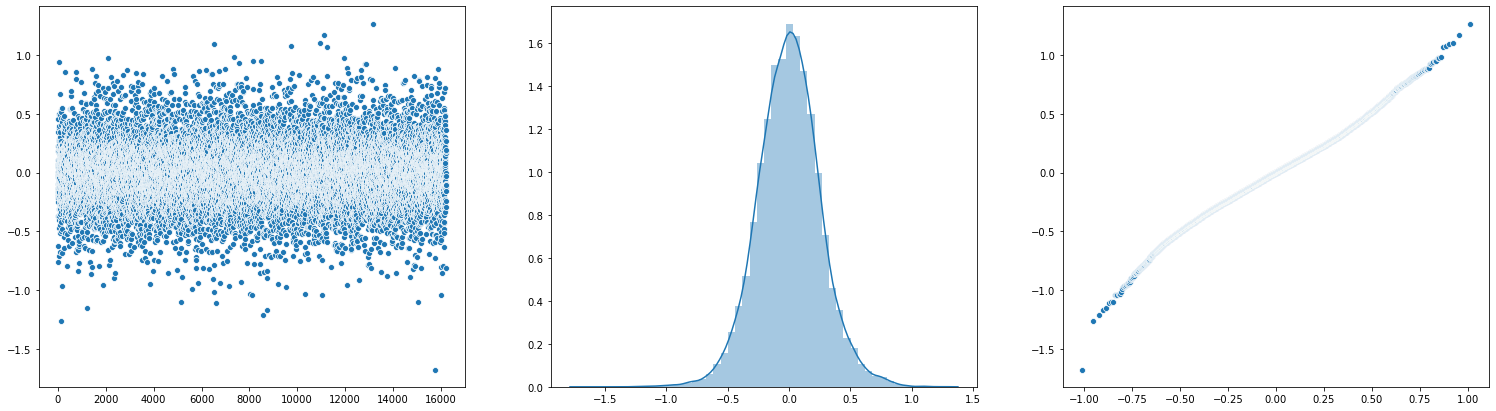

In [11]:
#Training residuals
res = (y - clf_lr.predict(X))
fig, axs = plt.subplots(ncols=3,figsize=(26,7))
qq,_ = probplot(res,sparams=(0,np.std(res)))
sns.scatterplot(np.arange(X.shape[0]),res,ax=axs[0])
sns.distplot(res,ax=axs[1])
sns.scatterplot(qq[0],qq[1],ax=axs[2])

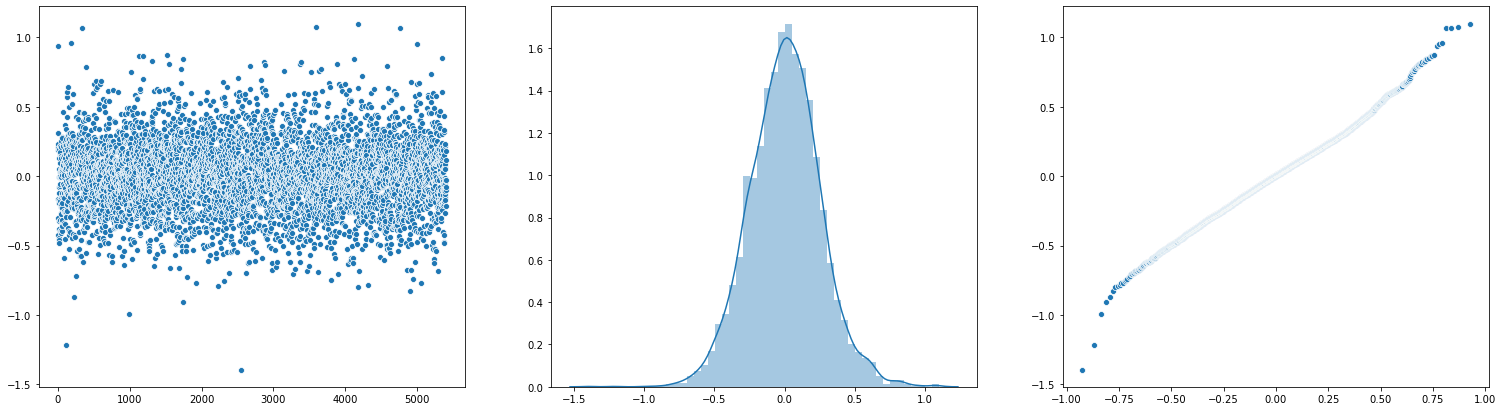

In [12]:
#Test residuals
res = (y_test - clf_lr.predict(x_test))
fig, axs = plt.subplots(ncols=3,figsize=(26,7))
qq,_ = probplot(res,sparams=(0,np.std(res)))
sns.scatterplot(np.arange(x_test.shape[0]),res,ax=axs[0])
sns.distplot(res,ax=axs[1])
sns.scatterplot(qq[0],qq[1],ax=axs[2])

Residuals show similar spread across the different training and test samples. Error terms appear to be homoscedastic. The error distribution appears to be normal, but shows slight deviation(refer to QQ-plot) from the actual normal distribution centered at 0 with standard deviation same as the residual standard deviation. 

Now, lets try to do a simple interpretation of the results based on standardized coefficient values. I will be comparing scaled absolute values of coefficients from the baseline model and the final model. Final model does not take into account many variables fed into the baseline and those features can be assumed to have no(0) effect in the final model.

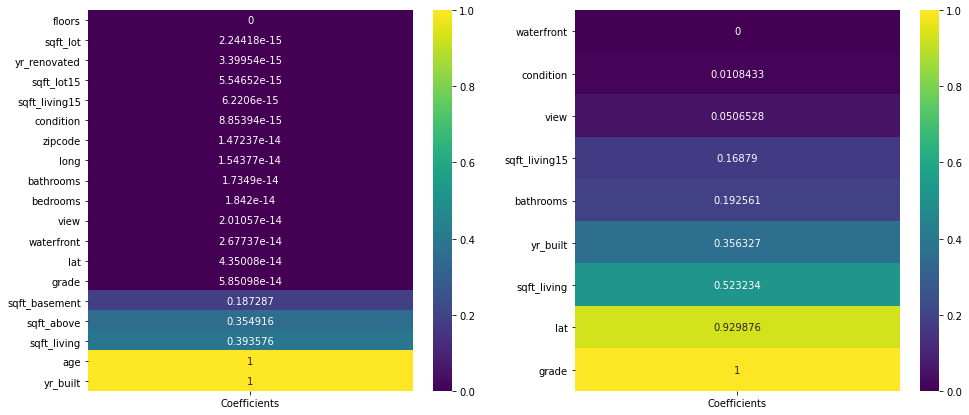

In [13]:
#Coefficient visualization
coeff = np.abs(clf_baseline.coef_)
coef_baseline = (coeff- (np.min(coeff)))/ (np.max(coeff) - np.min(coeff))
index = np.argsort(coef_baseline)
coef_baseline = coef_baseline[index]
base_cols = df_test.drop('price',axis=1).columns
cols = []
for i in index:
  cols.append(base_cols[i])
df_baseline = pd.DataFrame({"Coefficients": coef_baseline },
                  index=cols)



coeff = np.abs(clf_lr.coef_)
coef_final = (coeff- (np.min(coeff)))/ (np.max(coeff) - np.min(coeff))
index = np.argsort(coef_final)
coef_final = coef_final[index]
final_cols = df_test[selected_cols].columns
cols = []
for i in index:
  cols.append(final_cols[i])
df_final = pd.DataFrame({"Coefficients": coef_final},
                  index=cols)


fig, axs = plt.subplots(ncols=2,figsize=(16,7))
sns.heatmap(df_baseline, annot=True, fmt="g", cmap='viridis',ax=axs[0])
sns.heatmap(df_final, annot=True, fmt="g", cmap='viridis',ax=axs[1])
plt.show()

There are significant differences between the baseline and the final model. 'grade' comes on top for the final model, whereas, baseline relies on square footages. Final model does not include any square footage but 'sqft_living', with a lesser importance as compared to baseline. But square footage and grade variables are significantly correlated for both the models and hence, their  actual contributions are obscured. This is the reason, we see such difference between the two(classic Multicollinearity problem here). However, one interesting observation is significant rise of the variable 'lat' in the final model. This is due to a significant bump in 'lat' correlation with 'price' after data transformations. This was not intended, but it happened anyway.

Lets see how correlations changed for variables(for whom the final correlation is greater than 0.3)after the data transformations, represented as percentages.

In [14]:
#Correlation differences after transformations
corr_at = df_train.corr().drop('price')['price']
corr_bt = df_train_pristine.corr().drop('price')['price']
((corr_at - corr_bt)/corr_bt)*100*(corr_at>0.3).astype(int)

bedrooms         11.249865
bathrooms         4.417632
sqft_living      -1.212805
sqft_lot          0.000000
floors           21.437827
waterfront       -0.000000
view            -12.209138
condition         0.000000
grade             5.706640
sqft_above       -0.900616
sqft_basement    -2.334194
yr_built          0.000000
yr_renovated     -0.000000
zipcode          -0.000000
lat              47.368203
long              0.000000
sqft_living15     6.447858
sqft_lot15        0.000000
age               0.000000
Name: price, dtype: float64

'lat' has almost 50% increase in its correlation value. This looks logical, as location can be related to property prices due to several underlying factors. A better transformation for location may give us even better results.

However, to interpret feature importance just by numbers is not sufficient and nothing can beat basic common sense and domain knowledge. You may use the number to back your claims, but numbers alone should not be trusted.

We may further improve the predictive power by adding polynomial features. But keep in mind, with more features, comes a problem of low interpretability and higher variance. Also, the variables are no longer independant from each other due to addition of interaction variables. Lets run a polynomial regression with degree 3.

In [15]:
#Polynomial Features regression
scaler = StandardScaler()
poly = PolynomialFeatures(3)
X = df_train[selected_cols].to_numpy()
y = df_train['price'].to_numpy()
X = poly.fit_transform(scaler.fit_transform(X))
x_test = df_test[selected_cols].to_numpy()
x_test = poly.fit_transform(scaler.transform(x_test))
y_test = df_test['price'].to_numpy()

clf_pr = LR()
clf_pr.fit(X,y)

r2 = clf_pr.score(x_test,y_test)
adj_r2 = 1-(1-r2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)
print('R2 - ' + str(r2))
print('adj R2 - ' + str(adj_r2))

R2 - 0.8350923323252912
adj R2 - 0.8280912348940994


Polynomial features with degree 3 bumped the adjusted R squared to almost 0.829 on the test set.


But I think I am missing something here. Location seems important, atleast per my limited knowledge of the Real Estate, yet there is no effective utilization in my model. Selected features only contain latitude, but not longitude. Neither did zipcode come into picture. Latitude can hardly do much by itself. Zipcode seems promising, but being categorical with close to 70 distinct values makes me uncomfortable to include a one hot encoded version of it. 

So, I will try to see if zipcode can be converted to an ordinal variable. 
Approach is simple, I will group the data by zipcodes and create another variable 'ordinal_zip' which would be a sorted version of the zipcode based on mean price value per zipcode. Instead of price, I will use price per squarefoot which I think is a better(again, a hunch) variable to base my new feature.

After getting a ordinal version of zip code as per the price per squarefoot, I will try to regress this new variable on latitude and longitude, so that I dont have to take zipcodes into considerations at all. Latitude and Longitude should contain enough information to uniquely identify a zipcode. After all, you cant have two zipcodes for same geo coordinates(I hope the world works this way). For this regression, I will use a Random Forest Regressor, as the geomap of zipcodes looks like blocks of latitudes and longitude, which seems like ideal condition for a decision tree based approaches. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


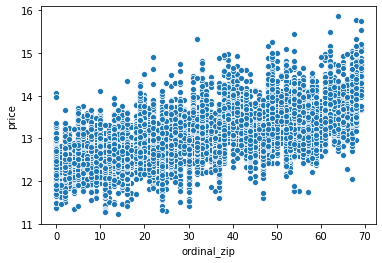

In [16]:
# Build ordinal zip code
def get_ordinal_zip(x):
  return(zip.loc[x]['ordinal_zip'])

# df_train['zip_index'] = df_train['zipcode'].apply(get_ordinal_zip)
df_train['ppsf'] = df_train_pristine['price']/df_train_pristine['sqft_living'] #New variable, price per square foot
zip = df_train.groupby('zipcode').mean()
zip.sort_values('ppsf',inplace=True)
zip['ordinal_zip'] = np.arange(len(zip))

df_train['ordinal_zip'] = df_train['zipcode'].apply(get_ordinal_zip) # New feature
sns.scatterplot(df_train['ordinal_zip'],df_train['price'])

Now, we have a new variable, which is like zipcode, but ordered as per mean property prices in a particulat area. Higher the value of this code, higher the average prices in that area. Refer to the graph above.

Now, we will create a random forest regressor to learn how latitude and longitude can be used to predict this new variable and use this regressor to predict these ordinal zip values in our test set.

R2 for predicting ordinal zip from lat and long - 0.9993881706302199


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


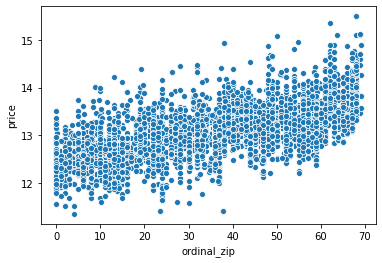

In [17]:
#Learn to predict ordinal zipcode directly from latitude and longitude
X = df_train[['lat','long']].to_numpy()
y = df_train['ordinal_zip'].to_numpy()


clf_zip = RFR()
clf_zip.fit(X,y)
print('R2 for predicting ordinal zip from lat and long - ' + str(clf_zip.score(X,y)))

def reg_zip_index(abc):
  x = abc.to_numpy()[np.newaxis,...]
  return(clf_zip.predict(x)[0])

df_test['ordinal_zip'] = df_test[['lat','long']].apply(reg_zip_index,axis=1)
sns.scatterplot(df_test['ordinal_zip'],df_test['price'])

regressor trained on training data is able to replicate same relationship between ordinal zip and the price in the test data. So, now we have a function which can produce ordinal zip values from latitude and longitude.

Lets see if including this new variable can improve the performance of simple linear regression.

In [18]:
# regression with ordinal zipcode
selected_cols1 = selected_cols + ['ordinal_zip'] # add new variable to already selected columns
scaler = StandardScaler()
X = df_train[selected_cols1].to_numpy()
y = df_train['price'].to_numpy()
X = scaler.fit_transform(X)
x_test = df_test[selected_cols1].to_numpy()
x_test = scaler.transform(x_test)
y_test = df_test['price'].to_numpy()

clf_lr = LR()
clf_lr.fit(X,y)

R2 = clf_lr.score(x_test,y_test)
print('R2 - ' + str(R2))
print('adj R2 - ' + str(1-(1-R2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))
print(df_test.drop('price',axis=1).columns.to_list())
print(clf_baseline.coef_)

R2 - 0.861174960757134
adj R2 - 0.8609174959217429
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 'ordinal_zip']
[-3.55569533e+04  3.35012965e+04 -7.55438621e+17  4.50883181e+03
 -2.01308049e+02  5.15912978e+04  3.87926239e+04  1.71957379e+04
  1.12506178e+05  6.81232197e+17  3.59481685e+17 -1.91942039e+18
  6.72645937e+03 -2.84622958e+04  8.36976071e+04 -2.98327804e+04
  1.21412619e+04 -1.08474171e+04 -1.91942039e+18]


This is a significant improvement in the performance of the linear regression, where we had to add only one ordinal variable instead of 70 categorical variables. Location sure is an important factor. I am also curious to know how the stepwise regression process changes after addition of the new variable. Let's see

In [19]:
selected_cols1 = step_reg(df_train.drop('ppsf',axis=1),target_col,significance_threshold,adj_r2_threshold)   

grade
0.5006567336952261
ordinal_zip
0.7489130795866255
min tolerance - grade - 0.9621154885018081
sqft_living
0.8350748841780038
min tolerance - grade - 0.40053452503849896
sqft_living15
0.8445599356674345
min tolerance - sqft_living - 0.32455711568099466
waterfront
0.8533141257553756
min tolerance - sqft_living - 0.32372140215177136
condition
0.8578996495508531
min tolerance - sqft_living - 0.32105389955364805
adjusted r2 voilated


Significant change. Infact, Latitude is gone, as its already coded in ordinal zip. our new feature achieves second place, with three most important features as - Grade, Location(zip, lat,long) and Sqft Area.


Lets see if a simple neural network can capture such a location feature. I would be using non transformed data with the neural network. However I would be standardizing the complete data for numerical stability of the network.
The network is composed of two hidden stacks and an output unit. Hidden units are Relu activated and loss is calculated as MSE. Dropout has been used to help prevent the overfitting.

In [20]:
# Simple Neural Net
selected_cols1 = selected_cols
if 'long' not in selected_cols1:
  selected_cols1 = selected_cols + ['long']
scalerx = StandardScaler()
scalery = StandardScaler()
# X = df_train.drop('price',axis=1).to_numpy()
X = df_train_pristine[selected_cols1].to_numpy()
y = df_train_pristine['price'].to_numpy()
X = scalerx.fit_transform(X)
y = scalery.fit_transform(y[...,np.newaxis])[:,0]
# x_test = df_test.drop('price',axis=1).to_numpy()
x_test = df_test_pristine[selected_cols1].to_numpy()
x_test = scalerx.transform(x_test)
y_test = df_test_pristine['price'].to_numpy()
y_test = scalery.transform(y_test[...,np.newaxis])[:,0]


model = basic_net(32,32,0.3)
model.compile(optimizer='rmsprop', loss=loss)
print('Training model...')
model.fit(X,y,epochs=75,batch_size=64,verbose=0,validation_split=0.2,callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)
print('Testing...')
y_pred = model.predict(x_test)


r2 = r2_score(y_test,y_pred)
adj_r2 = 1-(1-r2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)
print('R2 - ' + str(r2))
print('adj R2 - ' + str(adj_r2))

Training model...
Testing...
R2 - 0.8757541677311271
adj R2 - 0.8755237414843376


This model shows a significantly better performance with non transformed data with same features as the linear regression. A feature 'long' has been added(if it was not already selected) to see if location('lat' and 'long') could improve the results and it turns out, it does. You may re run this cell by excluding 'long' and see a significant drop in the performance.
However, I would be interested to know if it gains any performance by adding our new feature - ordinal zip. Maybe, next time.

Well, Neural network did save us from feature transformations. It might have learnt those transformations in the hidden units. There is no sure way of knowing this, but it definitely learnt some important transformations, which helped it's output unit(which essentially is just a simple linear regressor acting upon learnt transformations) achieve a good score without receiving any explicit data transformations from us.